In [15]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

In [260]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 前処理 ###
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# 欠損値-1をNaNに変える
train['price_am'].replace(-1, np.nan, inplace=True)
train['price_pm'].replace(-1, np.nan, inplace=True)

# 特徴量の追加
train['price'] = (train['price_am'] + train['price_pm']) / 2
test['price'] = (test['price_am'] + test['price_pm']) / 2

print(f'データ数：{len(train)}')
print(train.head())
print('データ型:')
print(train.dtypes)
print('===========================================================')
print(f'データ数：{len(test)}')
print(test.head())

データ数：2101
    datetime   y  client  close  price_am  price_pm  price
0 2010-07-01  17       0      0       NaN       NaN    NaN
1 2010-07-02  18       0      0       NaN       NaN    NaN
2 2010-07-03  20       0      0       NaN       NaN    NaN
3 2010-07-04  20       0      0       NaN       NaN    NaN
4 2010-07-05  14       0      0       NaN       NaN    NaN
データ型:
datetime    datetime64[ns]
y                    int64
client               int64
close                int64
price_am           float64
price_pm           float64
price              float64
dtype: object
データ数：365
    datetime  client  close  price_am  price_pm  price
0 2016-04-01       1      0         3         2    2.5
1 2016-04-02       0      0         5         5    5.0
2 2016-04-03       1      0         2         2    2.0
3 2016-04-04       1      0         1         1    1.0
4 2016-04-05       0      0         1         1    1.0


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_2722/2601419327.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['price_am'].replace(-1, np.nan, inplace=True)
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_2722/2601419327.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [262]:
#
# 'price_am'と'price_pm'の欠損値を月毎の平均値で埋めたい
#
train_ = train.set_index('datetime', inplace=False)
train_monthly = train_[['price_am']].resample('M').mean()
print(train_monthly.head(10))

print('===============================')
print('月毎の平均午前価格を表示（NaN月は除外）')
train_monthly_no_nan = train_monthly.iloc[6:]
print(train_monthly_no_nan.head())

#
# 欠損日に対応月の平均値を代入
#

# 月ごとの平均を計算
monthly_avg = train_monthly_no_nan.groupby(train_monthly_no_nan.index.month).mean()
print('==============================')
print('各年の月毎に平均午前価格を平均')
print(monthly_avg)



            price_am
datetime            
2010-07-31       NaN
2010-08-31       NaN
2010-09-30       NaN
2010-10-31       NaN
2010-11-30       NaN
2010-12-31       NaN
2011-01-31  0.285714
2011-02-28  0.928571
2011-03-31  2.225806
2011-04-30  1.300000
月毎の平均午前価格を表示（NaN月は除外）
            price_am
datetime            
2011-01-31  0.285714
2011-02-28  0.928571
2011-03-31  2.225806
2011-04-30  1.300000
2011-05-31  0.580645
各年の月毎に平均午前価格を平均
          price_am
datetime          
1         0.291667
2         0.841338
3         2.209677
4         1.226667
5         0.561290
6         0.513333
7         0.746667
8         0.389032
9         0.740000
10        0.638710
11        0.473333
12        0.640000


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_2722/11894758.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_monthly = train_[['price_am']].resample('M').mean()


In [264]:
#train['datetime'] = train['datetime'].apply(lambda x: x.timestamp())
#test['datetime'] = test['datetime'].apply(lambda x: x.timestamp())




train_copy = train.set_index('datetime', inplace=False)

# 学習データ
train_df = train_copy.iloc[:-365]
y_train = train_df['y']              #目的変数y
x_train = train_df.drop('y', axis=1) #説明変数X

# テストデータ
test_df = train_copy.iloc[-365:]  #テストデータ
y_test = test_df['y']              #目的変数y
X_test = test_df.drop('y', axis=1) #説明変数X

In [266]:
regressor = xgb.XGBRegressor()
regressor.fit(x_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [268]:
# 特徴量重要度（Feature Importances）
df_importance = pd.DataFrame(zip(x_train.columns,
                                 regressor.feature_importances_),
                             columns=["Features","Importance"])
df_importance = df_importance.sort_values("Importance",
                                          ascending=False)
df_importance #確認

,Features,Importance
4,price,0.794333
2,price_am,0.096752
1,close,0.088737
0,client,0.010519
3,price_pm,0.009659


<Axes: xlabel='Features'>

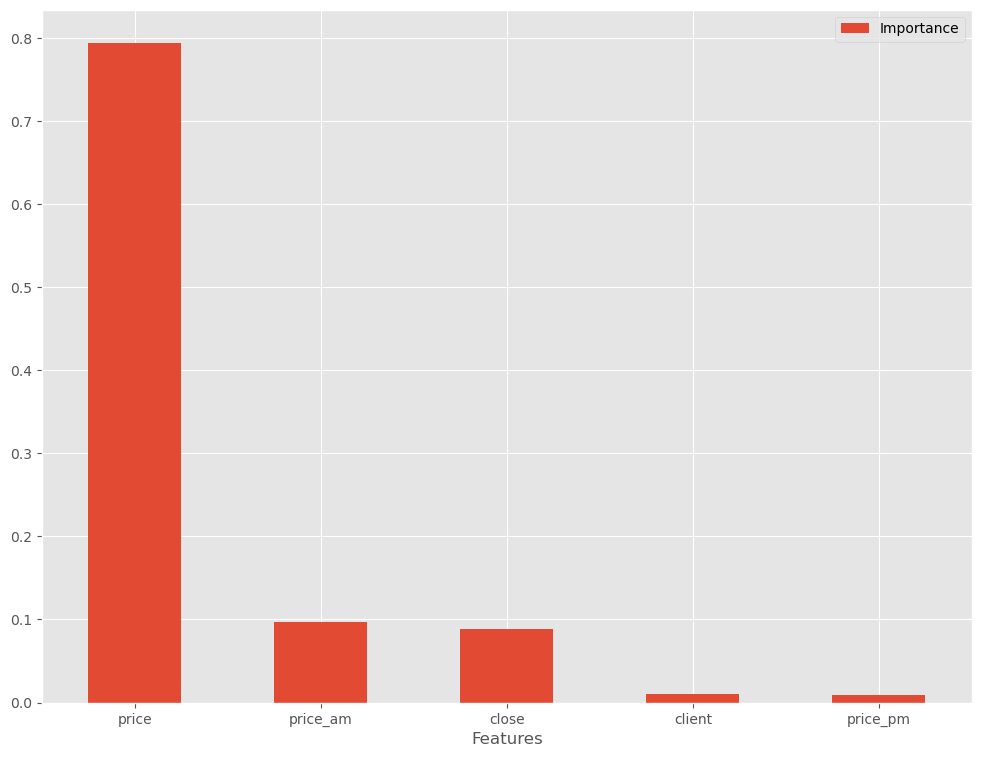

In [270]:
# グラフ化
df_importance.plot.bar(x='Features',y='Importance', rot=0)

In [272]:
# 予測
train_pred = regressor.predict(x_train.values)
test_pred = regressor.predict(x_test.values)

# 精度指標（テストデータ）
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(y_test, test_pred))

ValueError: Feature shape mismatch, expected: 5, got 4

ValueError: x and y must have same first dimension, but have shapes (365,) and (421,)

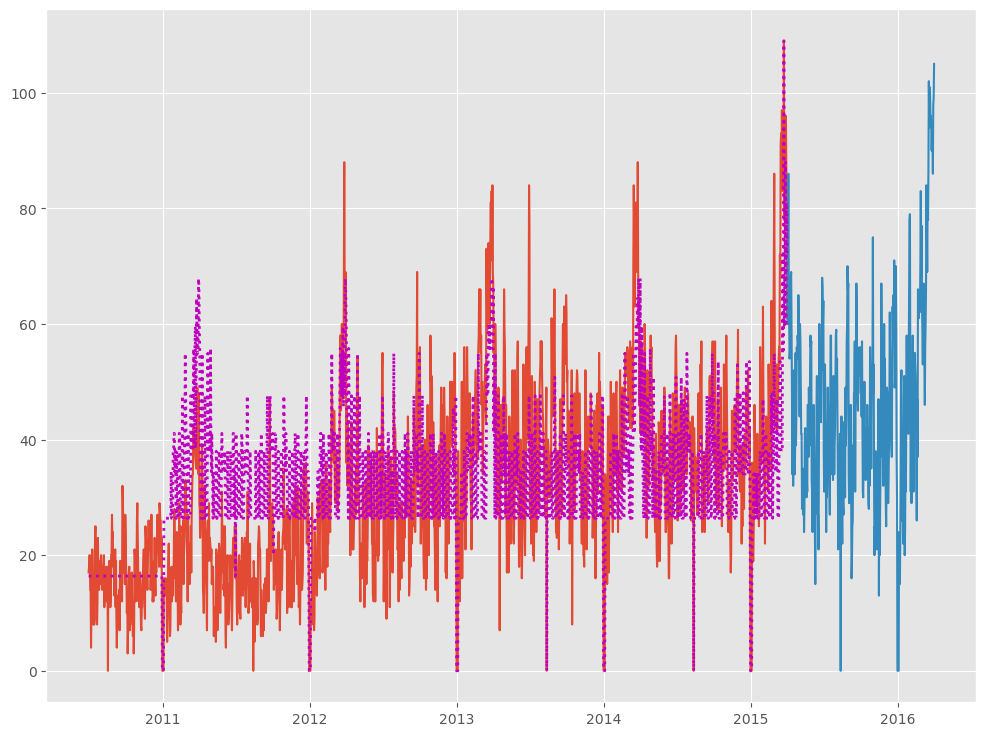

In [274]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m") 
plt.legend()

In [276]:
prices = [0] * (365*2) + [1, 2, 3, 4, 5] * int((365*3) / 5)
dates = pd.date_range(start='2019-01-01', periods=365*5, freq='D')
# DataFrameの作成
df = pd.DataFrame({'Date': dates, 'Price': prices})

# 日付をインデックスに設定
df.set_index('Date', inplace=True)

# 価格が0のところをNaNに変換
df['Price'].replace(0, np.nan, inplace=True)

# 価格が0でない値を使って月ごとの平均を計算
monthly_avg = df['Price'].resample('M').mean()

# インデックスをto_periodで月単位に変換
period_index = df.index.to_period('M')

# NaNのところを月の平均値で置き換え
df['Price'] = df['Price'].fillna(period_index.map(monthly_avg))

print(df.head(30))  # 最初の30日分のデータを表示

/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_2722/500515313.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].replace(0, np.nan, inplace=True)
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_2722/500515313.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Price'].resample('M').mean()


TypeError: "value" parameter must be a scalar, dict or Series, but you passed a "Index"

In [278]:
test_ = test.set_index('datetime', inplace=False)
predictions = regressor.predict(test_.values)

submit = pd.DataFrame({
    'Date': test['datetime'],
    'Prediction': predictions
})
submit.columns = submit.iloc[0]
submit

,2016-04-01 00:00:00,37.004902
0,2016-04-01,37.004902
1,2016-04-02,64.428406
2,2016-04-03,53.499695
3,2016-04-04,48.111176
4,2016-04-05,37.984936
...,...,...
360,2017-03-27,59.571461
361,2017-03-28,67.874664
362,2017-03-29,55.777596
363,2017-03-30,55.778164


In [281]:
submit.to_csv('submit_XGBoost.csv', index=False)